# Synthesis planning

### Full-route reranking.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import wandb

api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("liac/steer-test")

summary_list, config_list, name_list = [], [], []
for run in runs:
    if int(run.name.split('-')[-1]) < 234:
        continue
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(pd.Series(run.summary._json_dict))

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        pd.Series({k: v for k,v in run.config.items()
          if not k.startswith('_')}))

    # .name is the human-readable name of the run.
    name_list.append(run.name)


df_summ = pd.concat(summary_list, axis=1)
df_conf = pd.concat(config_list, axis=1)

df = pd.concat([df_summ, df_conf]).T

corr_cols = df.columns[df.columns.str.startswith('corr')]

In [2]:
from steer.evaluation.synthesis import load_default_tasks

tasks = load_default_tasks()

smi = {}
prompt = {}
for t in tasks:
    smi[t.id] = t.smiles
    prompt[t.id] = t.prompt

In [22]:
# def plot_corrs(model, ax):
#     # Select the random, and see what's going on with some tasks with high variation
#     gr = df[['model', *corr_cols]].sort_values('model')
#     gr = gr.replace('deepseek', 'deepseek-v3')

#     data = gr[gr['model'] == model].melt(id_vars='model').replace('NaN', np.nan)
#     data.dropna(inplace=True)
#     data['smiles'] = data['variable'].apply(lambda x: len(smi[x.split('_')[1]]))
#     data.sort_values('smiles', inplace=True)

#     sns.stripplot(data=data, x='variable', y='value', hue='model',  ax=ax, jitter=True, palette='magma', alpha=0.7)
#     sns.violinplot(data=data, x='variable', y='value', hue='model', ax=ax, palette='magma_r', split=True, alpha=0.6)


# fig, ax = plt.subplots(4,2,figsize=(30, 20), gridspec_kw={'wspace': 0.01, 'hspace':0.01}, sharey=True, sharex=True)
# ax = ax.ravel()
# models = ['gpt-4o-mini', 'qwq-32b', 'gpt-4o', 'deepseek-v3', 'deepseek-r1','claude-3-5-sonnet', 'random']
# for i, x in enumerate(ax):
#     if i==len(models):
#         break
#     plot_corrs(models[i], x)

#     x.legend(loc=1)

#     for tick in x.get_xticklabels():
#         tick.set_rotation(90)
#     x.axhline(0, color='black', lw=1)

#     cum = -0.5
#     for j in [3,3,2,5]:
#         cum += j
#         x.axvline(cum, color='red', lw=1)

# plt.show()

### Let's do more aggregated stuff

Text(0, 0.5, 'Average Correlation with Ground Truth scores.')

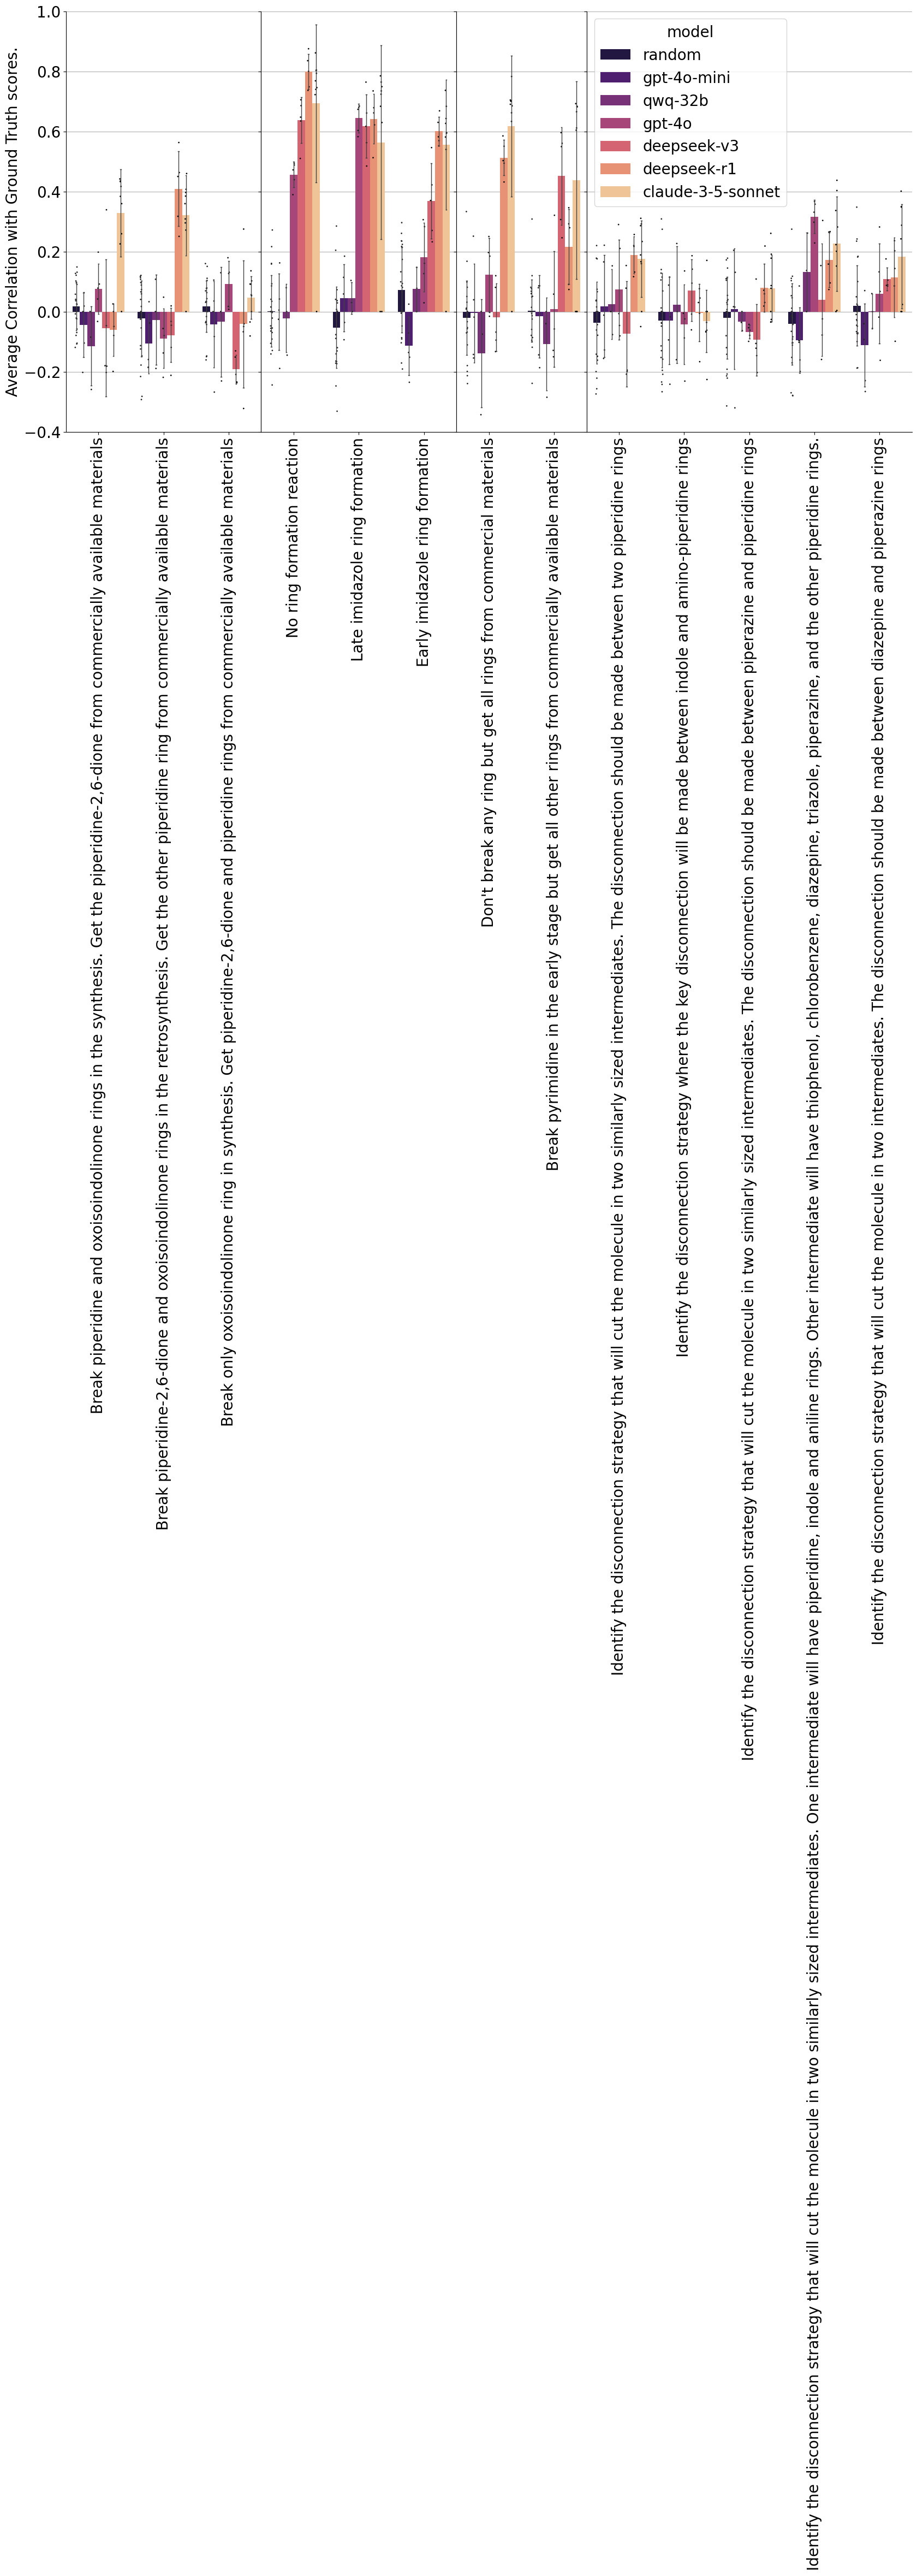

In [7]:
# handle nan values

plt.rcParams['font.size'] = 20

agg = df.replace('NaN', np.nan).fillna(0).melt(id_vars='model', value_vars=corr_cols)

agg = agg.reset_index()
agg['smiles'] = agg['variable'].apply(lambda x: smi[x.split('_')[1]])
agg['prompt'] = agg['variable'].apply(lambda x: prompt[x.split('_')[1]])

wratios = {s:0 for s in smi.values()}
for tid, s in smi.items():
    wratios[s] += 1
wratios = [(k,v, len(k)) for k,v in wratios.items()]
wratios = sorted(wratios, key=lambda x: x[2], reverse=False)

fig, ax = plt.subplots(1,len(wratios), figsize=(20, 10), gridspec_kw={"hspace": 0., "wspace": 0., "width_ratios": [i for s,i,l in wratios]}, sharey=True)

# For each molecule
for i,s in enumerate([s for s,_,_ in wratios]):
    sdata = agg[agg['smiles'] == s].replace('deepseek', 'deepseek-v3')
    sns.barplot(
        data=sdata,
        x='prompt',
        y='value',
        hue='model',
        # alpha=0.6,
        ax=ax[i],
        hue_order=['random', 'gpt-4o-mini', 'qwq-32b', 'gpt-4o', 'deepseek-v3', 'deepseek-r1','claude-3-5-sonnet'],
        palette='magma',
        capsize=0.1,
        errorbar='sd',
        err_kws={'linewidth': 1, "zorder":10},
        linewidth=1,
        zorder=5
    )

    sns.stripplot(
        data=sdata,
        x='prompt',
        y='value',
        hue='model',
        # alpha=0.6,
        ax=ax[i],
        hue_order=['random', 'gpt-4o-mini', 'qwq-32b', 'gpt-4o', 'deepseek-v3', 'deepseek-r1','claude-3-5-sonnet'],
        palette="dark:k",
        dodge=True,
        jitter=True,
        size=2,
        legend=False,
        zorder=5
    )

    # rotate x labels
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(90)

    ax[i].set_xlabel('')
    ax[i].spines['top'].set_visible(False)
    # if i != 0:
    #     # Remove spines
    #     ax[i].yaxis.set_visible(False)
    if i == 3:
        ax[i].spines['right'].set_visible(False)

    # hide legend for all except the last
    if i != 3:
        ax[i].get_legend().remove()

    ax[i].grid(axis='y',zorder=1)
    ax[i].set_ylim(-0.4, 1)
    

ax[0].set_ylabel('Average Correlation with Ground Truth scores.')

# fig.savefig('correlations.svg', dpi=300)

In [8]:
wratios

[('CCN1[C@@H](COC2=CC(C(N(C3C(NC(CC3)=O)=O)C4)=O)=C4C=C2)CCCC1', 3, 59),
 ('CC1=CC=C(Cl)C(C(N[C@H](C(O)=O)CNC(CN2C(C=C(F)C(C)=N3)=C3NC2=O)=O)=O)=C1F',
  3,
  72),
 ('CN1CCN(C2=CC=C(N(C3=NC(N(C4=CC=CC(C(C)(C)O)=N4)N(CC=C)C5=O)=C5C=N3)[H])C=C2)CC1',
  2,
  79),
 ('CP(C1=CC=C(NCC#CC2=CC(C(NC3CCN(CC(N4CCC(CN5CCN(C(C[C@@H]6N=C(C7=CC=C(Cl)C=C7)C(C(C)=C(C)S8)=C8N9C6=NN=C9C)=O)CC5)CC4)=O)CC3)=CC=C%10)=C%10N2CC(F)(F)F)C=C1)(C)=O',
  5,
  160)]

In [12]:
# get the order of the ticks from the figure
from itertools import chain

prompt_order = list(chain(*[[t.get_text() for t in ax[i].get_xticklabels()] for i in range(4)]))

letters = 'ABCDEFGHIJKLMN'
for i,j in zip(letters, prompt_order):
    print(i, " : ", j)

A  :  Break piperidine and oxoisoindolinone rings in the synthesis. Get the piperidine-2,6-dione from commercially available materials
B  :  Break piperidine-2,6-dione and oxoisoindolinone rings in the retrosynthesis. Get the other piperidine ring from commercially available materials
C  :  Break only oxoisoindolinone ring in synthesis. Get piperidine-2,6-dione and piperidine rings from commercially available materials
D  :  No ring formation reaction
E  :  Late imidazole ring formation
F  :  Early imidazole ring formation
G  :  Don't break any ring but get all rings from commercial materials
H  :  Break pyrimidine in the early stage but get all other rings from commercially available materials
I  :  Identify the disconnection strategy that will cut the molecule in two similarly sized intermediates. The disconnection should be made between two piperidine rings
J  :  Identify the disconnection strategy where the key disconnection will be made between indole and amino-piperidine rings
K 

## remake plot but more compressed - agg details

/tmp/ipykernel_2203511/3890822484.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels([f"{letters[j]}" for j in range(cax_ticks)], size=16)
/tmp/ipykernel_2203511/3890822484.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels([f"{letters[j]}" for j in range(cax_ticks)], size=16)
/tmp/ipykernel_2203511/3890822484.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels([f"{letters[j]}" for j in range(cax_ticks)], size=16)
/tmp/ipykernel_2203511/3890822484.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels([f"{letters[j]}" for j in range(cax_ticks)], size=16)
/tmp/ipykern

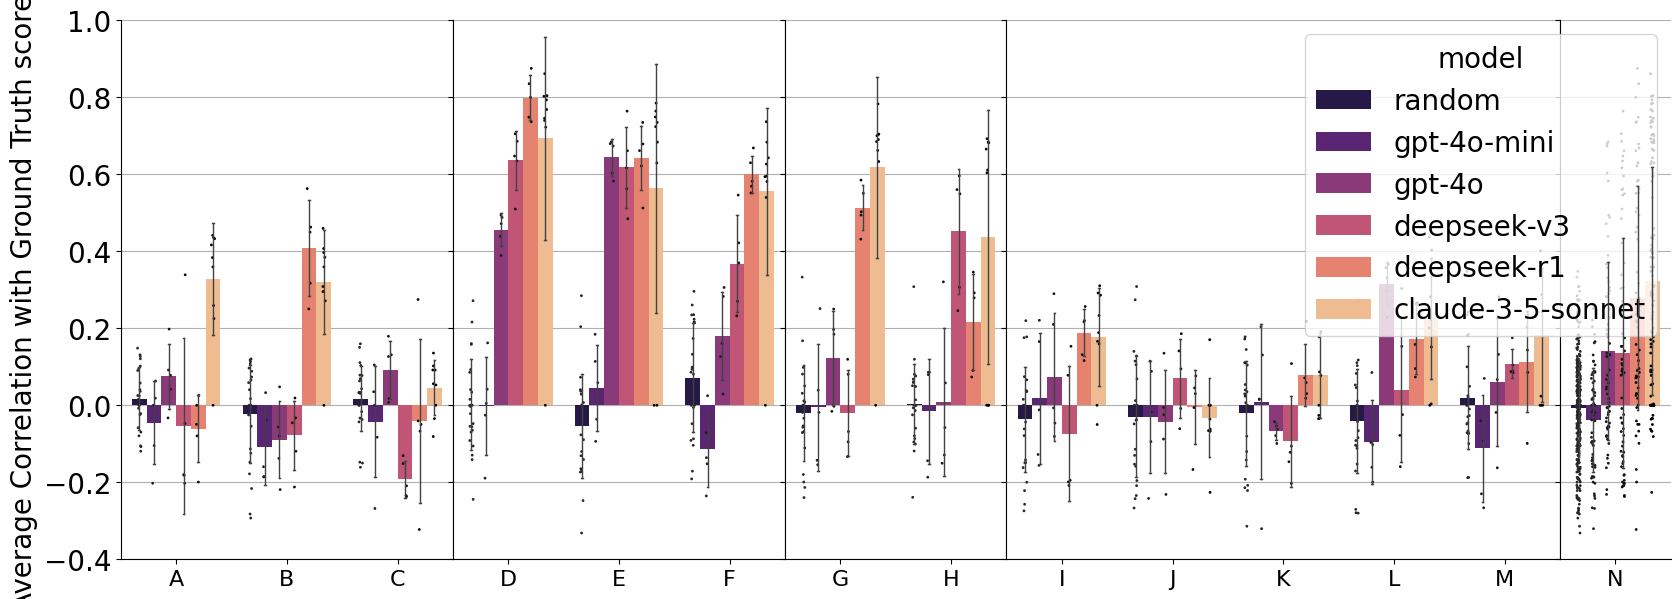

In [55]:
# handle nan values
agg = df.replace('NaN', np.nan).fillna(0).melt(id_vars='model', value_vars=corr_cols)

agg = agg.reset_index()
agg['smiles'] = agg['variable'].apply(lambda x: smi[x.split('_')[1]])
agg['prompt'] = agg['variable'].apply(lambda x: prompt[x.split('_')[1]])

wratios = {s:0 for s in smi.values()}
for tid, s in smi.items():
    wratios[s] += 1
wratios = [(k,v, len(k)) for k,v in wratios.items()]
wratios = sorted(wratios, key=lambda x: x[2], reverse=False)

# append mean subplot
wratios.append(('mean', 1, 1000))

agg['model'] = agg['model'].replace('deepseek', 'deepseek-v3')

lmodels = ['random', 'gpt-4o-mini', 'gpt-4o', 'deepseek-v3', 'deepseek-r1','claude-3-5-sonnet']
agg = agg[agg['model'].isin(lmodels)]

letters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

fig, ax = plt.subplots(1,len(wratios), figsize=(20, 7), gridspec_kw={"hspace": 0., "wspace": 0., "width_ratios": [i for s,i,l in wratios]}, sharey=True)

# For each molecule
for i,s in enumerate([s for s,_,_ in wratios]):
    if i!=len(wratios)-1:
        sdata = agg[agg['smiles'] == s]
    else:
        sdata = agg.copy()
        sdata['prompt'] = "mean"

    sns.barplot(
        data=sdata,
        x='prompt',
        y='value',
        hue='model',
        # alpha=0.6,
        ax=ax[i],
        hue_order=lmodels,
        palette='magma',
        capsize=0.1,
        errorbar='sd',
        err_kws={'linewidth': 1, "zorder":10},
        linewidth=1,
        zorder=5
    )

    sns.stripplot(
        data=sdata,
        x='prompt',
        y='value',
        hue='model',
        # alpha=0.6,
        ax=ax[i],
        hue_order=lmodels,
        palette="dark:k",
        dodge=True,
        jitter=True,
        size=2,
        legend=False,
        zorder=5
    )

    ax[i].set_xlabel('')
    ax[i].spines['top'].set_visible(False)
    # if i != 0:
    #     # Remove spines
    #     ax[i].yaxis.set_visible(False)
    if i == len(wratios)-1:
        ax[i].spines['right'].set_visible(False)

    # hide legend for all except the last
    if i != len(wratios)-1:
        ax[i].get_legend().remove()

    ax[i].grid(axis='y',zorder=1)
    ax[i].set_ylim(-0.4, 1)

    cax_ticks = len(ax[i].get_xticks())
    ax[i].set_xticklabels([f"{letters[j]}" for j in range(cax_ticks)], size=16)
    letters = letters[cax_ticks:]

ax[0].set_ylabel('Average Correlation with Ground Truth scores.')

fig.savefig('correlations_agg.svg', dpi=300)

In [ ]:
# Get the order of the ticks from the figure
from itertools import chain

In [46]:
sdata[]

,index,model,variable,value,smiles,prompt
0,0,claude-3-5-sonnet,corr_00813afd159c009f6a6c9bf1207b07f4,0.166059,CP(C1=CC=C(NCC#CC2=CC(C(NC3CCN(CC(N4CCC(CN5CCN...,Identify the disconnection strategy that will ...
1,1,claude-3-5-sonnet,corr_00813afd159c009f6a6c9bf1207b07f4,-0.049988,CP(C1=CC=C(NCC#CC2=CC(C(NC3CCN(CC(N4CCC(CN5CCN...,Identify the disconnection strategy that will ...
2,2,gpt-4o-mini,corr_00813afd159c009f6a6c9bf1207b07f4,-0.127753,CP(C1=CC=C(NCC#CC2=CC(C(NC3CCN(CC(N4CCC(CN5CCN...,Identify the disconnection strategy that will ...
3,3,random,corr_00813afd159c009f6a6c9bf1207b07f4,-0.221706,CP(C1=CC=C(NCC#CC2=CC(C(NC3CCN(CC(N4CCC(CN5CCN...,Identify the disconnection strategy that will ...
4,4,gpt-4o,corr_00813afd159c009f6a6c9bf1207b07f4,0.210107,CP(C1=CC=C(NCC#CC2=CC(C(NC3CCN(CC(N4CCC(CN5CCN...,Identify the disconnection strategy that will ...
...,...,...,...,...,...,...
723,723,deepseek-r1,corr_ea8df340d54596eda93e23f04dff3a9b,-0.098922,CP(C1=CC=C(NCC#CC2=CC(C(NC3CCN(CC(N4CCC(CN5CCN...,Identify the disconnection strategy that will ...
724,724,deepseek-r1,corr_ea8df340d54596eda93e23f04dff3a9b,0.143346,CP(C1=CC=C(NCC#CC2=CC(C(NC3CCN(CC(N4CCC(CN5CCN...,Identify the disconnection strategy that will ...
725,725,deepseek-r1,corr_ea8df340d54596eda93e23f04dff3a9b,0.202353,CP(C1=CC=C(NCC#CC2=CC(C(NC3CCN(CC(N4CCC(CN5CCN...,Identify the disconnection strategy that will ...
726,726,deepseek-r1,corr_ea8df340d54596eda93e23f04dff3a9b,0.235973,CP(C1=CC=C(NCC#CC2=CC(C(NC3CCN(CC(N4CCC(CN5CCN...,Identify the disconnection strategy that will ...


## Evolution of model series

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import wandb

api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("liac/steer-test")

summary_list, config_list, name_list = [], [], []
for run in runs:
    if int(run.name.split('-')[-1]) < 363:
        continue
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(pd.Series(run.summary._json_dict))

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        pd.Series({k: v for k,v in run.config.items()
          if not k.startswith('_')}))

    # .name is the human-readable name of the run.
    name_list.append(run.name)


df_summ = pd.concat(summary_list, axis=1)
df_conf = pd.concat(config_list, axis=1)

df = pd.concat([df_summ, df_conf]).T

corr_cols = df.columns[df.columns.str.startswith('corr')]

/tmp/ipykernel_2599920/2867504172.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  summary_list.append(pd.Series(run.summary._json_dict))
/tmp/ipykernel_2599920/2867504172.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  summary_list.append(pd.Series(run.summary._json_dict))
/tmp/ipykernel_2599920/2867504172.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  summary_list.append(pd.Series(run.summary._json_dict))


/tmp/ipykernel_2599920/3195593565.py:90: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels([f"{letters[j]}" for j in range(cax_ticks)], size=16)
/tmp/ipykernel_2599920/3195593565.py:90: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels([f"{letters[j]}" for j in range(cax_ticks)], size=16)
/tmp/ipykernel_2599920/3195593565.py:90: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels([f"{letters[j]}" for j in range(cax_ticks)], size=16)
/tmp/ipykernel_2599920/3195593565.py:90: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels([f"{letters[j]}" for j in range(cax_ticks)], size=16)
/tmp/ipykern

Text(0, 0.5, 'Average Correlation with Ground Truth scores.')

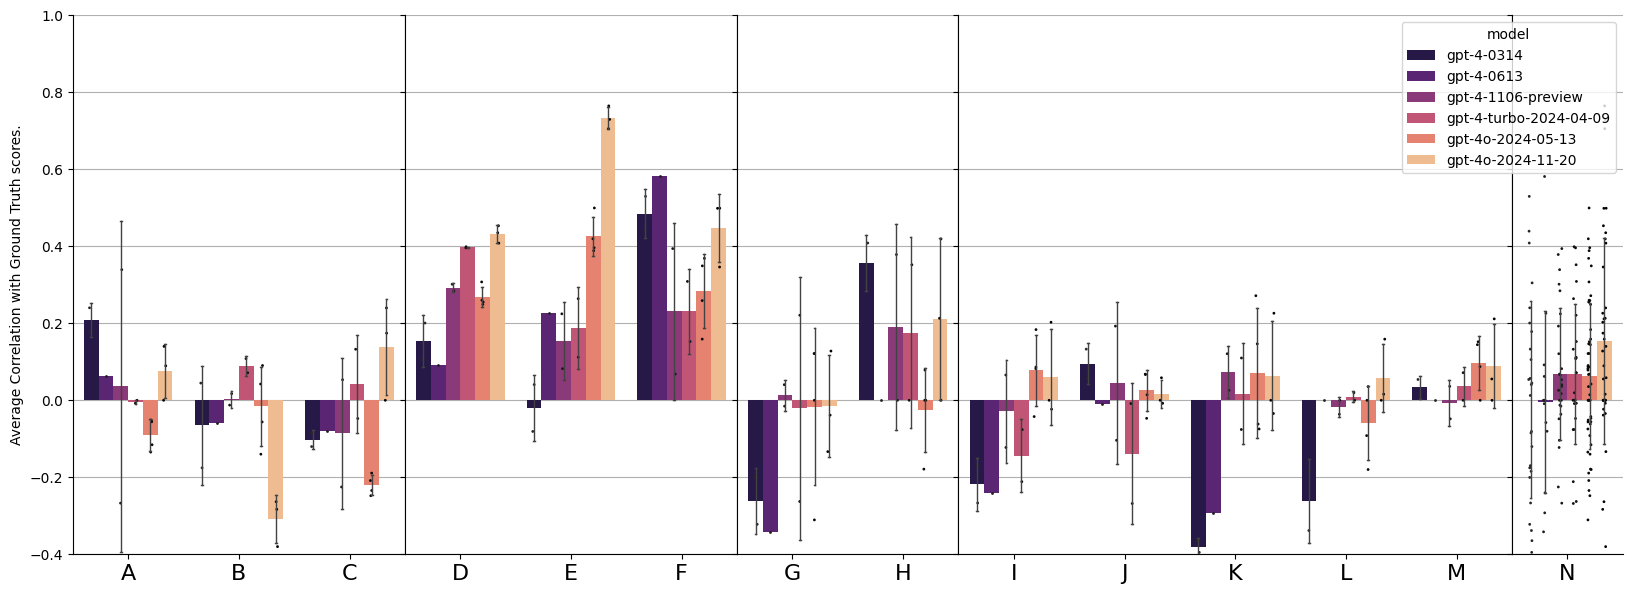

In [10]:
# handle nan values
agg = df.replace('NaN', np.nan).fillna(0).melt(id_vars='model', value_vars=corr_cols)

agg = agg.reset_index()
agg['smiles'] = agg['variable'].apply(lambda x: smi[x.split('_')[1]])
agg['prompt'] = agg['variable'].apply(lambda x: prompt[x.split('_')[1]])

wratios = {s:0 for s in smi.values()}
for tid, s in smi.items():
    wratios[s] += 1
wratios = [(k,v, len(k)) for k,v in wratios.items()]
wratios = sorted(wratios, key=lambda x: x[2], reverse=False)

# append mean subplot
wratios.append(('mean', 1, 1000))

agg['model'] = agg['model'].replace('deepseek', 'deepseek-v3')

# lmodels = ['random', 'gpt-4o-mini', 'gpt-4o', 'deepseek-v3', 'deepseek-r1','claude-3-5-sonnet']
lmodels =  [
        "gpt-4-0314",
        "gpt-4-0613",
        "gpt-4-1106-preview",
        "gpt-4-turbo-2024-04-09",
        "gpt-4o-2024-05-13",
        "gpt-4o-2024-11-20",
    ]
agg = agg[agg['model'].isin(lmodels)]

letters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

fig, ax = plt.subplots(1,len(wratios), figsize=(20, 7), gridspec_kw={"hspace": 0., "wspace": 0., "width_ratios": [i for s,i,l in wratios]}, sharey=True)

# For each molecule
for i,s in enumerate([s for s,_,_ in wratios]):
    if i!=len(wratios)-1:
        sdata = agg[agg['smiles'] == s]
    else:
        sdata = agg.copy()
        sdata['prompt'] = "mean"

    sns.barplot(
        data=sdata,
        x='prompt',
        y='value',
        hue='model',
        # alpha=0.6,
        ax=ax[i],
        hue_order=lmodels,
        palette='magma',
        capsize=0.1,
        errorbar='sd',
        err_kws={'linewidth': 1, "zorder":10},
        linewidth=1,
        zorder=5
    )

    sns.stripplot(
        data=sdata,
        x='prompt',
        y='value',
        hue='model',
        # alpha=0.6,
        ax=ax[i],
        hue_order=lmodels,
        palette="dark:k",
        dodge=True,
        jitter=True,
        size=2,
        legend=False,
        zorder=5
    )

    ax[i].set_xlabel('')
    ax[i].spines['top'].set_visible(False)
    # if i != 0:
    #     # Remove spines
    #     ax[i].yaxis.set_visible(False)
    if i == len(wratios)-1:
        ax[i].spines['right'].set_visible(False)

    # hide legend for all except the last
    if i != len(wratios)-1:
        ax[i].get_legend().remove()

    ax[i].grid(axis='y',zorder=1)
    ax[i].set_ylim(-0.4, 1)

    cax_ticks = len(ax[i].get_xticks())
    ax[i].set_xticklabels([f"{letters[j]}" for j in range(cax_ticks)], size=16)
    letters = letters[cax_ticks:]

ax[0].set_ylabel('Average Correlation with Ground Truth scores.')

# fig.savefig('correlations_agg.svg', dpi=300)

In [12]:
# Plot LM scores vs route size

# Each entry in df has a distribution. Get all those points

import json
import os


def _route_size(rt):
    rt = str(rt)
    return rt.count("'type': 'reaction'")


def get_scores_len(data):
    scores = [d['lmdata']['routescore'] for d in data]
    sizes = [_route_size(d) for d in data]
    return scores, sizes


def distrib_from_file(row):
    dirp = row['results_dir']
    path = os.path.join('..', dirp)

    results = {}
    for fname in os.listdir(path):
        with open(os.path.join(path, fname), 'r') as f:
            sc, rt_len = get_scores_len(json.load(f))
            results[fname.split('.')[0]] = {
                "scores": sc,
                "rt_len": rt_len
            }
    return results


all_results = {}
for i in range(len(df)):
    all_results[i] = distrib_from_file(df.iloc[i])

In [13]:
# for task in tasks_order:
#     fig, ax = plt.subplots(1,4,figsize=(15, 5), sharey=True, gridspec_kw={'wspace': 0.01, 'hspace':0.01})
#     models = ['random', 'gpt-4o-mini', 'gpt-4o', 'claude-3-5-sonnet']
#     results = {}
#     for k, v in all_results.items():
#         scs, rt_lens = v[task]['scores'], v[task]['rt_len']
#         idx = models.index(df.iloc[k]['model'])
#         sns.kdeplot(x=rt_lens, y=scs, ax=ax[idx])
#         ax[idx].set_title(df.iloc[k]['model'])
#     fig.suptitle(task)
#     plt.show()

NameError: name 'tasks_order' is not defined

# Direct search

In [61]:
import pandas as pd

import wandb

api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("liac/synth-search")

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(pd.Series(run.summary._json_dict))

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        pd.Series({k: v for k,v in run.config.items()
          if not k.startswith('_')}))

    # .name is the human-readable name of the run.
    name_list.append(run.name)


df_summ = pd.concat(summary_list, axis=1)
df_conf = pd.concat(config_list, axis=1)

rdf = pd.concat([df_summ, df_conf]).T
rdf = rdf.drop([4]).reset_index(drop=True)
rdf

/tmp/ipykernel_2203511/181303880.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  summary_list.append(pd.Series(run.summary._json_dict))
/tmp/ipykernel_2203511/181303880.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  summary_list.append(pd.Series(run.summary._json_dict))


,_runtime,_step,_timestamp,_wandb,ms_00813afd159c009f6a6c9bf1207b07f4,ms_1002fe2d610a74e4478530e12ab930e3,ms_1823f3241b82133bbca85d6576cbed65,ms_280b79ef56e06a8af1a7d6b72c52148d,ms_46f06d1a1e359b3230cfc1b81473a474,ms_4bfe366ec7f5d64678d500f9084cbb35,...,ms_dfc8116ec63329c437281f7a40dda876,ms_e579d80f176371344bab95ea15e6b9ab,ms_ea8df340d54596eda93e23f04dff3a9b,model,llm_prob,llm_prompt,llm_vision,llm_weight,results_dir,wandb_project
0,6404.128546,12,1738003283.368003,{'runtime': 6403},9.134526,8.378378,2.285714,5.298526,0.810811,6.568115,...,5.581395,2.41576,8.677437,,0,steer.llm.prompts.search,False,1,data/2025-01-27_175431,synth-search
1,9067.174508,12,1738006348.377796,{'runtime': 9066},9.280588,7.619048,1.894737,4.803097,0.322581,7.704596,...,6.956522,2.314784,9.657218,claude-3-5-sonnet,0.05,steer.llm.prompts.search,False,1,data/2025-01-27_180113,synth-search
2,15816.165298,9.0,1738014664.933727,NaN,9.6,10.0,2.903226,8.241703,NaN,NaN,...,10.0,4.75548,NaN,deepseek-3,0.5,steer.llm.prompts.search,False,1,data/2025-01-27_182720,synth-search
3,13081.977276,6.0,1738023582.683004,NaN,NaN,0.0,2.857143,7.714286,NaN,NaN,...,4.375,2.488095,NaN,deepseek-r1,0.5,steer.llm.prompts.search,False,1,data/2025-01-27_214132,synth-search
4,19808.785065,12,1738092077.162764,{'runtime': 19808},9.411765,5,4.328358,6.722065,0,7.287913,...,4.636872,0.678879,8.509752,gpt-4o-mini,0.5,steer.llm.prompts.search,False,1,data/2025-01-28_145055,synth-search
5,11990.073356,10,1738087303.453273,{'runtime': 12420},9.649894,4.545455,3.046875,7.688416,NaN,NaN,...,7.531646,0.599873,7.402597,claude-3-5-sonnet,0.5,steer.llm.prompts.search,False,1,data/2025-01-28_154145,synth-search
6,43230.201461,6,1738585917.977229,{'runtime': 43230},9.766334,0,NaN,NaN,0,8.095238,...,NaN,NaN,6.325,deepseek-r1,0.5,steer.llm.prompts.search,False,1,data/2025-02-03_013119,synth-search
7,2140.303434,1,1738545350.047555,{'runtime': 2140},NaN,NaN,NaN,NaN,NaN,8.47619,...,NaN,NaN,NaN,claude-3-5-sonnet,0.5,steer.llm.prompts.search,False,1,data/2025-02-03_014001,synth-search
8,3298.286056,1,1738546709.938943,{'runtime': 3298},NaN,NaN,NaN,NaN,0,NaN,...,NaN,NaN,NaN,deepseek-3,0.5,steer.llm.prompts.search,False,1,data/2025-02-03_014323,synth-search
9,2135.105774,1,1738549249.450651,{'runtime': 2134},NaN,NaN,NaN,NaN,0,NaN,...,NaN,NaN,NaN,gpt-4o,0.5,steer.llm.prompts.search,False,1,data/2025-02-03_024506,synth-search


In [62]:
rmidx = [6,7,8,9,11, 12,13]
rdf = rdf.drop(rmidx).reset_index(drop=True)
rdf

,_runtime,_step,_timestamp,_wandb,ms_00813afd159c009f6a6c9bf1207b07f4,ms_1002fe2d610a74e4478530e12ab930e3,ms_1823f3241b82133bbca85d6576cbed65,ms_280b79ef56e06a8af1a7d6b72c52148d,ms_46f06d1a1e359b3230cfc1b81473a474,ms_4bfe366ec7f5d64678d500f9084cbb35,...,ms_dfc8116ec63329c437281f7a40dda876,ms_e579d80f176371344bab95ea15e6b9ab,ms_ea8df340d54596eda93e23f04dff3a9b,model,llm_prob,llm_prompt,llm_vision,llm_weight,results_dir,wandb_project
0,6404.128546,12,1738003283.368003,{'runtime': 6403},9.134526,8.378378,2.285714,5.298526,0.810811,6.568115,...,5.581395,2.41576,8.677437,,0,steer.llm.prompts.search,False,1,data/2025-01-27_175431,synth-search
1,9067.174508,12,1738006348.377796,{'runtime': 9066},9.280588,7.619048,1.894737,4.803097,0.322581,7.704596,...,6.956522,2.314784,9.657218,claude-3-5-sonnet,0.05,steer.llm.prompts.search,False,1,data/2025-01-27_180113,synth-search
2,15816.165298,9.0,1738014664.933727,NaN,9.6,10.0,2.903226,8.241703,NaN,NaN,...,10.0,4.75548,NaN,deepseek-3,0.5,steer.llm.prompts.search,False,1,data/2025-01-27_182720,synth-search
3,13081.977276,6.0,1738023582.683004,NaN,NaN,0.0,2.857143,7.714286,NaN,NaN,...,4.375,2.488095,NaN,deepseek-r1,0.5,steer.llm.prompts.search,False,1,data/2025-01-27_214132,synth-search
4,19808.785065,12,1738092077.162764,{'runtime': 19808},9.411765,5,4.328358,6.722065,0,7.287913,...,4.636872,0.678879,8.509752,gpt-4o-mini,0.5,steer.llm.prompts.search,False,1,data/2025-01-28_145055,synth-search
5,11990.073356,10,1738087303.453273,{'runtime': 12420},9.649894,4.545455,3.046875,7.688416,NaN,NaN,...,7.531646,0.599873,7.402597,claude-3-5-sonnet,0.5,steer.llm.prompts.search,False,1,data/2025-01-28_154145,synth-search
6,14023.63632,12,1738567890.795134,{'runtime': 14023},8.794266,0.789474,2.697368,5.24724,0,8.306585,...,1.655629,2.246541,7.737937,gpt-4o,0.5,steer.llm.prompts.search,False,1,data/2025-02-03_043739,synth-search


In [63]:
# Have to read the routes directly from the files and then plot them
import json
import os

from steer.evaluation.synthesis import load_default_tasks


def get_scores(row):
    dirp = row['results_dir']
    path = os.path.join('../../synthegy/', dirp)
    tasks = load_default_tasks()

    task_scores = {}
    for t in tasks:
        try:
            with open(os.path.join(path, f"{t.id}.json"), 'r') as f:
                rt = json.load(f)
                scores, _ = t.evaluate(rt['routes'])
                task_scores[t.id] = scores
        except:
            continue
    return task_scores


all_results = []
for i in range(len(rdf)):
    print(i)
    res = get_scores(rdf.iloc[i])
    if len(res)>0:
        all_results.append(res)

0
1
2
3
4
5
6


In [64]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# dfs = []
# for i in range(len(rdf)):
#     model = rdf.iloc[i]['model']
#     llm_prob = rdf.iloc[i]['llm_prob']
#     scores = all_results[i]

#     data = [(k, l) for k, v in scores.items() for l in v]
#     data = pd.DataFrame(data, columns=['task', 'score'])
#     data['model'] = model or "vanilla"
#     data['llm_prob'] = llm_prob
#     data['model:llm_prob'] = data['model'] + ":" + data['llm_prob'].astype(str)
#     dfs.append(data)

# adf = pd.concat(dfs)


# adf['smiles'] = adf['task'].apply(lambda x: smi[x])
# adf['prompt'] = adf['task'].apply(lambda x: prompt[x])

# # sort by prompt_order
# adf = adf.sort_values('prompt', key=lambda x: x.map({v: i for i, v in enumerate(prompt_order)}))

# wratios = {s:0 for s in smi.values()}
# for tid, s in smi.items():
#     wratios[s] += 1
# wratios = [(k,v, len(k)) for k,v in wratios.items()]
# wratios = sorted(wratios, key=lambda x: x[2], reverse=False)

# fig, ax = plt.subplots(2, 4, figsize=(30, 10), gridspec_kw={'wspace': 0.0, 'hspace': 0.04, 'width_ratios':[i for s,i,l in wratios]})
# for i in range(1,4):
#     ax[1,i-1].sharey(ax[1,i])

# for i, s in enumerate([s for s,_,_ in wratios]):
#     filt = adf[adf['smiles'] == s]
#     # ax[0].set_title(f"{model or 'Vanilla'} - {llm_prob}", fontsize=10)
#     sns.stripplot(data=filt, x='prompt', y='score', hue='model:llm_prob', dodge=True, ax=ax[0, i], jitter=True, alpha=0.7, palette="dark:k", size=1, legend=False)
#     sns.barplot(data=filt, x='prompt', y='score', hue='model:llm_prob', ax=ax[0, i], palette='magma', capsize=0.1,
#         hue_order = ['vanilla:0', 'gpt-4o-mini:0.5', 'deepseek-3:0.5', 'deepseek-r1:0.5', 'claude-3-5-sonnet:0.05', 'claude-3-5-sonnet:0.5'],
#         errorbar='ci',
#         err_kws={'linewidth': 1, "zorder":10},
#         linewidth=1,
#         zorder=5
#     )

#     # Plot also the number of solutions
#     sns.barplot(data=filt, x='prompt', y='score', hue='model:llm_prob', ax=ax[1, i], palette='magma', estimator=len,
#         hue_order = ['vanilla:0', 'gpt-4o-mini:0.5', 'deepseek-3:0.5', 'deepseek-r1:0.5', 'claude-3-5-sonnet:0.05', 'claude-3-5-sonnet:0.5'],
#     )

#     # rotate x labels
#     ax[0, i].set_xticks([])
#     ax[0, i].set_xlabel('')
#     # for tick in ax[0,i].get_xticklabels():
#     #     tick.set_rotation(90)
#     for tick in ax[1,i].get_xticklabels():
#         tick.set_rotation(90)

#     if i != 0:
#         ax[0, i].set_ylabel('')
#         ax[0, i].set_yticks([])
#         ax[1, i].set_ylabel('')
#         ax[1, i].set_yticks([])

#     # Remove all legends except the last
#     ax[0, i].get_legend().remove()
#     if i != 3:
#         ax[1, i].get_legend().remove()

#     ax[0, i].set_ylim(0., 10.05)

# ax[0, 0].set_ylabel('Route Scores')
# ax[1, 0].set_ylabel('Number of solutions')
    
# fig.savefig('search_scores.svg', dpi=300)

### same, aggregate

/tmp/ipykernel_2203511/3566952577.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0, i].set_xticklabels([f"{letters[j]}" for j in range(cax_ticks)], size=16)
/tmp/ipykernel_2203511/3566952577.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0, i].set_xticklabels([f"{letters[j]}" for j in range(cax_ticks)], size=16)
/tmp/ipykernel_2203511/3566952577.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0, i].set_xticklabels([f"{letters[j]}" for j in range(cax_ticks)], size=16)
/tmp/ipykernel_2203511/3566952577.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0, i].set_xticklabels([f"{letters[j]}" for j in range(cax_ticks)], size=

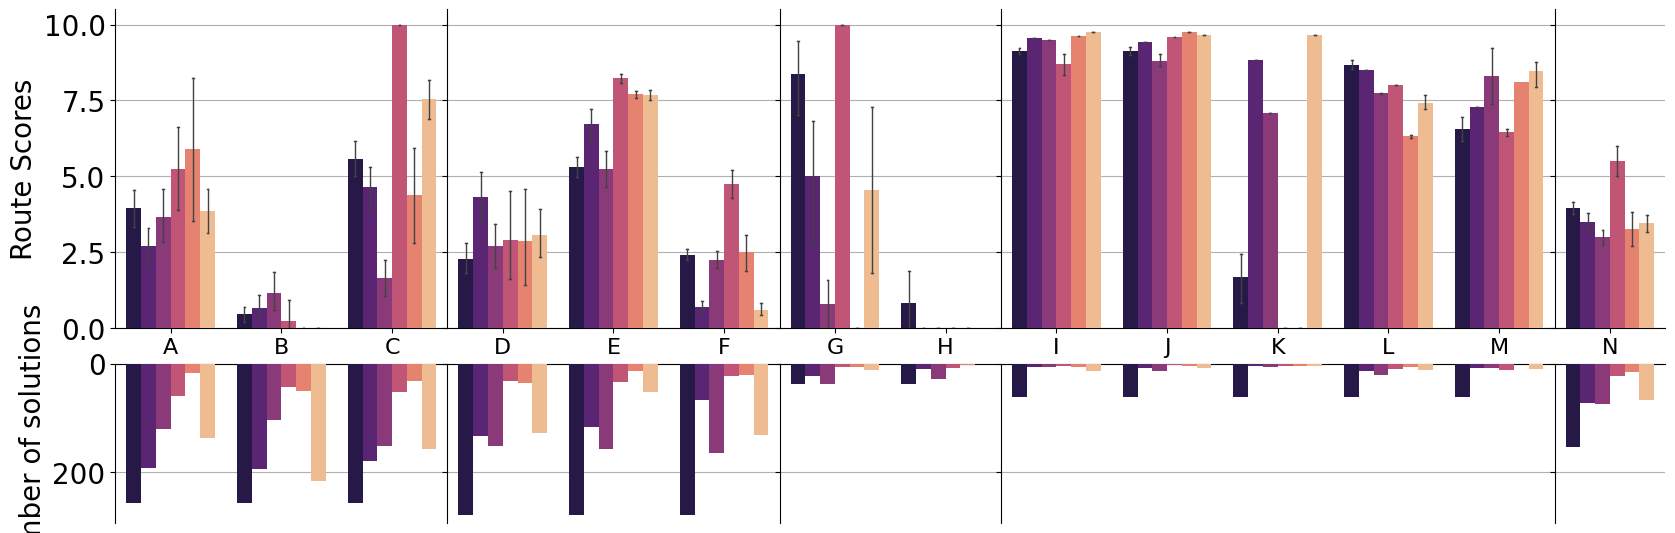

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 20

dfs = []
for i in range(len(rdf)):
    model = rdf.iloc[i]['model']
    llm_prob = rdf.iloc[i]['llm_prob']
    scores = all_results[i]

    data = [(k, l) for k, v in scores.items() for l in v]
    data = pd.DataFrame(data, columns=['task', 'score'])
    data['model'] = model or "vanilla"
    data['llm_prob'] = llm_prob
    data['model:llm_prob'] = data['model'] + ":" + data['llm_prob'].astype(str)
    dfs.append(data)

adf = pd.concat(dfs)

# Exclude 0.05 models
lmodels = ['vanilla:0', 'gpt-4o-mini:0.5', 'gpt-4o:0.5', 'deepseek-3:0.5', 'deepseek-r1:0.5', 'claude-3-5-sonnet:0.5']
adf = adf[adf['model:llm_prob'].isin(lmodels)]


adf['smiles'] = adf['task'].apply(lambda x: smi[x])
adf['prompt'] = adf['task'].apply(lambda x: prompt[x])

# sort by prompt_order
adf = adf.sort_values('prompt', key=lambda x: x.map({v: i for i, v in enumerate(prompt_order)}))

wratios = {s:0 for s in smi.values()}
for tid, s in smi.items():
    wratios[s] += 1
wratios = [(k,v, len(k)) for k,v in wratios.items()]
wratios = sorted(wratios, key=lambda x: x[2], reverse=False)
wratios.append(('mean', 1, 1000))

fig, ax = plt.subplots(
    2, len(wratios), figsize=(20, 6.67), 
    gridspec_kw={
        'wspace': 0.0,
        'hspace': 0.15,
        'width_ratios':[i for s,i,l in wratios],
        'height_ratios':[1, 0.5],
    }
)
for i in range(1,len(wratios)):
    ax[1,i].invert_yaxis()
    ax[1,i-1].sharey(ax[1,i])
    ax[0,i-1].sharey(ax[0,i])

letters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

for i, s in enumerate([s for s,_,_ in wratios]):
    if i!=len(wratios)-1:
        filt = adf[adf['smiles'] == s]
    else:
        filt = adf.copy()
        filt['prompt'] = "mean"

    # ax[0].set_title(f"{model or 'Vanilla'} - {llm_prob}", fontsize=10)
    # sns.stripplot(data=filt, x='prompt', y='score', hue='model:llm_prob', dodge=True, ax=ax[0, i], jitter=True, alpha=0.7, palette="dark:k", size=1, legend=False)
    sns.barplot(data=filt, x='prompt', y='score', hue='model:llm_prob', ax=ax[0, i], palette='magma', capsize=0.1,
        hue_order = lmodels,
        errorbar='ci',
        err_kws={'linewidth': 1, "zorder":10},
        linewidth=1,
        zorder=5
    )

    # Plot also the number of solutions
    sns.barplot(
        data=filt, x='prompt', y='score', hue='model:llm_prob', ax=ax[1, i], palette='magma', 
        estimator=len if i!=len(wratios)-1 else lambda x: len(x)/13,
        hue_order = lmodels, zorder=5,
    )

    ax[0, i].grid(axis='y',zorder=1)
    ax[1, i].grid(axis='y',zorder=1)

    # rotate x labels
    ax[1, i].set_xticks([])
    ax[1, i].set_xlabel('')
    ax[0, i].set_xlabel('')
    # for tick in ax[0,i].get_xticklabels():
    #     tick.set_rotation(90)
    # for tick in ax[1,i].get_xticklabels():
    #     tick.set_rotation(90)

    if i != 0:
        ax[0, i].set_ylabel('')
        ax[0, i].set_yticklabels([])
        ax[1, i].set_ylabel('')
        ax[1, i].set_yticklabels([])

    # Remove all legends except the last
    ax[0, i].get_legend().remove()
    # if i != len(wratios)-1:
    ax[1, i].get_legend().remove()

    # remove spines
    ax[0, i].spines['top'].set_visible(False)
    ax[0, i].spines['right'].set_visible(False)
    ax[1, i].spines['bottom'].set_visible(False)
    ax[1, i].spines['right'].set_visible(False)

    # ax[0, i].set_ylim(0., 10.05)

    cax_ticks = len(ax[0, i].get_xticks())
    ax[0, i].set_xticklabels([f"{letters[j]}" for j in range(cax_ticks)], size=16)
    letters = letters[cax_ticks:]

ax[0, 0].set_ylabel('Route Scores')
ax[1, 0].set_ylabel('Number of solutions')
    
fig.savefig('search_scores_agg.svg', dpi=300)

# Mechanism generation

### Single-step selection

In [18]:
import os

from dotenv import load_dotenv
from openai import OpenAI

load_dotenv()


client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=os.getenv("OPENROUTER_API_KEY"),
)

completion = client.chat.completions.create(
  extra_headers={
    "HTTP-Referer": "<YOUR_SITE_URL>", # Optional. Site URL for rankings on openrouter.ai.
    "X-Title": "<YOUR_SITE_NAME>", # Optional. Site title for rankings on openrouter.ai.
  },
  model="deepseek/deepseek-r1",
  messages=[
    {
      "role": "user",
      "content": "What is the meaning of life?"
    }
  ]
)
print(completion.choices[0].message.content)

The question of life's meaning is profound and has been explored through various lenses, each offering unique insights:

1. **Philosophical Perspectives**: Existentialists propose that life inherently lacks meaning, and individuals must create their own through choices and passions. Thinkers like Camus suggest embracing life's absurdity while seeking personal purpose.

2. **Religious/Spiritual Views**: Many traditions attribute meaning to a divine plan or cosmic harmony. For example, Christianity emphasizes love and service to God, Buddhism focuses on ending suffering through enlightenment, and Hinduism highlights fulfilling one's dharma (duty).

3. **Scientific Angle**: Evolutionary biology posits survival and reproduction as life's drivers, while neuroscience explores how meaning arises from brain processes. However, humans often seek purpose beyond mere biology—curiosity, connection, and legacy.

4. **Personal Meaning**: Viktor Frankl, a Holocaust survivor, argued that meaning can b